## Table of Contents

- [Introduction to ID* Algorithm](#Introduction-to-ID*-Algorithm)
- [Example of using ID_star](#Example-of-using-ID_star)
- [ID* Algorithm](#ID*-Algorithm)
- [Walkthrough of ID* algorithm](#Walkthrough-of-ID*-algorithm)
    - [Starting graph (Figure 9a)](#Starting-graph-Figure-9a)
    - [ID* line 1](#ID*-line-1)
    - [ID* line 2](#ID*-line-2)
    - [ID* line 3](#ID*-line-3)
    - [ID* line 4](#ID*-line-4)
    - [ID* line 5](#ID*-line-5)
    - [ID* line 6](#ID*-line-6)
        - [Calculate the C-components](#Calculate-the-C-components)
        - [Get the markov pillow of each C-component](#ID*-line-6,-get-the-markov-pillow-of-each-C-component)
        - [Recursive calls for each C-component](#Recursive-calls-for-each-C-component)
        - [Probability Results for each C-component](#Probability-Results-for-each-C-component)
    - [Putting it all together after recursion](#Putting-it-all-together-after-recursion,-Back-to-line-6)
    - [Final Checkpoint](#Final-Checkpoint)
- [IDC* Algorithm](#IDC*-Algorithm)
- [Walkthrough of the IDC* Algorithm](#Walkthrough-of-the-IDC*-Algorithm)
    - [IDC* line 1](#IDC*-line-1)
    - [IDC* line 2](#IDC*-line-2)
    - [IDC* line 3](#IDC*-line-3)
    - [Prior to IDC* line 4](#Prior-to-IDC*-line-4)
    - [IDC* line 4](#IDC*-line-4)
    - [IDC* line 4, recursive step](#IDC*-line-4,-recursive-step)
        - [IDC* recursive call line 1-3](#IDC*-recursive-call-line-1-3)
        - [IDC* recursive call line 4](#IDC*-recursive-call-line-4)
    - [Final recursive call](#Final-recursive-call)
    - [Final IDC* Checkpoint](#Final-IDC*-Checkpoint)
    
    

# Introduction to ID* Algorithm

The **ID*** algorithm was developed by (I. Shpitser, J. Pearl 2007) for identifying counterfactual queries. **ID*** operates by taking a causal diagram $G$ and a conjunction of counterfactual events $\gamma$ as inputs. It will return an expression for the probability of $\gamma$, $P(\gamma)$ or **FAIL**. 

The **ID*** algorithm utilizes the **make-cg** algorithm also found in (I. Shpitser, J. Pearl 2007) during the implementation. The details **make-cg** algorithm are not explained here, however, its function is to make a counterfactual graph that **ID*** will use for calculating $P(\gamma)$.

It was later shown that the **ID*** algorithm is sound and complete (I. Shpitser, J. Pearl 2008).

# Example of using ID_star
The walkthrough shows each step of the algorithm, but first here is an example of using id_star with a simple graph and event.

The graph we are using is found in figure 9a from (I. Shpitser, J. Pearl 2008).

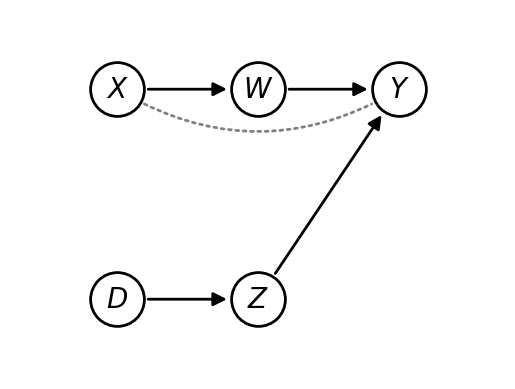

In [1]:
from y0.algorithm.identify.id_star import id_star
from y0.examples import figure_9a
from matplotlib import pyplot as plt
from y0.dsl import A, B, C, X, D, W, P, Y, Z

x, y, z, w, d = -X, -Y, -Z, -W, -D

figure_9a.graph.draw()  # This will be our starting graph

In [2]:
input_graph = figure_9a.graph
input_event = {Y @ -x: -y, X: +x, Z @ -d: -z, D: -d}
output_probability = id_star(input_graph, input_event)
print(f"The probability of our query:\n{output_probability}")

AttributeError: 'NxMixedGraph' object has no attribute 'get_markov_pillow'

In [3]:
# Imports needed for id_star walkthrough
%load_ext autoreload
%autoreload 2
import itertools as itt

from y0.algorithm.identify.id_star import (
    id_star,
    violates_axiom_of_effectiveness,
    remove_event_tautologies,
    get_events_of_district,
    get_cf_interventions,
    get_evidence,
    get_free_variables,
)
from y0.algorithm.identify.cg import make_counterfactual_graph, is_not_self_intervened
from y0.examples import figure_9a
from y0.dsl import One, Sum, Zero, Product
from y0.mutate.canonicalize_expr import canonicalize

from matplotlib_inline.backend_inline import set_matplotlib_formats

set_matplotlib_formats("svg")

x, y, z, w, d = -X, -Y, -Z, -W, -D


# ID* Algorithm
Here is the **ID*** algorithm as it appears in (I. Shpitser, J. Pearl 2008). Here we will walkthrough an example where each step is described. 

$\text{function }\mathbf{ {ID}^*}\left(G, \gamma\right) \\ \text{INPUT: } \text{ $G$ a causal diagram, $\gamma$ a conjunction of counterfactual events}. \\  \text{OUTPUT:  an expression for $P(\gamma)$ in terms of $P_*$ or $\mathbf{FAIL}$} $

* 1 if $\gamma=\varnothing$, return 1 
* 2 if ($\exists x_{x'..} \in \gamma$), return 0
* 3 if ($\exists x_{x..} \in \gamma$), return $\mathbf{ ID^*}(G,\gamma \backslash \{x_{x..}\})$
* 4 $(G',\gamma')=\mathbf{make-cg}(G,\gamma)$
* 5 if $\gamma'= \mathbf{INCONSISTENT}$ return 0
* 6 if $C(G')=\{S^1,...,S^k\},$ return $\sum_{\mathbf{V}(G')\backslash\gamma}\prod_{i}\mathbf{ID^*}(G,s^i_{\mathbf{v}(G')\backslash s^i})$
* 7 if $C(G')=\{S\}$ then
    * 8 if $\exists \mathbf{x,x'}$ s.t. $\mathbf{x} \neq \mathbf{x',x} \in \mathbf{sub}(S),\mathbf{x'} \in \mathbf{ev}(S),$ throw $\mathbf{FAIL}$
    * 9 else, let $\mathbf{x} = \bigcup \mathbf{sub}(S)$ return $P_\mathbf{x}(\mathbf{var}(S))$


# Walkthrough of ID* algorithm

We are going to start with the same graph and event that we started with for the make counterfactual graph walkthrough. 

## Starting graph (Figure 9a)
The starting graph and event for this walkthrough is the example corresponding to Figure 9a from (I. Shpitser, J. Pearl 2008)

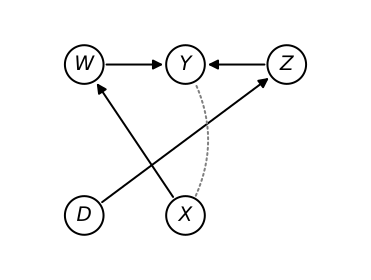

In [4]:
input_graph = figure_9a.graph
input_event = {Y @ -x: -y, X: +x, Z @ -d: -z, D: -d}
input_graph.draw()

![Figure9A.PNG](images/factual-world.PNG)


## ID* line 1
On line 1 we check that the event is not empty. If the event is empty, then **ID*** returns a probability of 1.

In [5]:
assert input_event is not None, "ID* line 1 failed, return One()"
print("Passed ID* line 1")

Passed ID* line 1


## ID* line 2
On line 2 we check $\gamma$ for inconsistencies. If $\gamma$ contains a counterfactual which violates the Axiom of Effectiveness, then **ID*** returns a probability of 0.


In [6]:
# Line 2: This violates the Axiom of Effectiveness
assert not violates_axiom_of_effectiveness(input_event), "ID* line 2 failed, return Zero()"
print("Passed ID* line 2")

Passed ID* line 2


## ID* line 3
On line 3 we check $\gamma$ for self interventions. If $\gamma$ contains self interventions then they can be removed from the query without effecting the probability. In this case **ID*** will be run again with the same input graph, but a reduced event that has removed event tautologies.


In [7]:
# Line 3: This is a tautological event and can be removed without affecting the probability
reduced_event = remove_event_tautologies(input_event)
if reduced_event == input_event:
    print("Passed ID* line 3")
else:
    print("The event contains a tautology, rerun ID* with reduced event")

Passed ID* line 3


## ID* line 4
Line 4 uses **make_counterfactual_graph** to construct a counterfactual graph $G'$ and relabeled event $\gamma'$. 


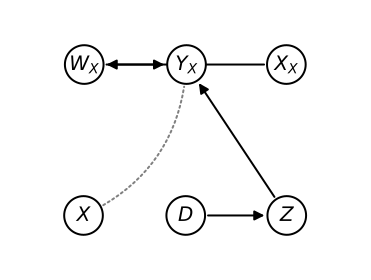

In [8]:
cf_graph, new_event = make_counterfactual_graph(input_graph, input_event)
cf_graph.draw()

![Figure9C.PNG](images/counterfactual-graph.png)

## ID* line 5
For line 5 we check for any inconsistencies which may have been found during the construction of **make_counterfactual_graph**. If $\gamma'$ is **None** then there was an inconsistency during the algorithm and **ID*** returns 0.


In [9]:
# We check that the new event $\gamma '$ is not inconsistent
assert new_event is not None, "ID* line 5 failed, return Zero()"
print("Passed ID* line 5")

Passed ID* line 5


## ID* line 6
Line 6 is the key line in the **ID*** algorithm. First we calculate the C-components of $G'$. If there is more than one C-component, line 6 will return a sum and a product that includes recursive calls to the **ID*** algorithm.

The outermost sum will sum over all vertices which are in the counterfactual graph but not in the event.

The product is the product of **ID*** for each C-component. Each call will have the original input $G$ (not the counterfactual graph $G'$) and a new event. The event of each call will be the variables in the C-component intervened on the markov pillow of the C-component, or the parents of all nodes in the C-component which are not themselves in the C-component.

### Calculate the C-components
We note here that self intervened variables such as $X_X$ are excluded from being in a C-component to prevent circular feedback loops. 

C-Component:frozenset({Z})
C-Component:frozenset({X, Y @ -X})
C-Component:frozenset({D})
C-Component:frozenset({W @ -X})


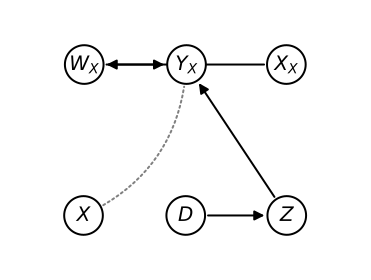

In [10]:
cf_graph.draw()
nodes = set(node for node in cf_graph.nodes() if is_not_self_intervened(node))
C_components = cf_graph.subgraph(nodes).get_c_components()
for c_component in C_components:
    print(f"C-Component:{c_component}")

### ID* line 6, get the markov pillow of each C-component
$\text{For each C-component we will intervene on the nodes that are needed to infer the value of the C-componenet (Markov Pillow)} \\
$

In [11]:
for c_component in C_components:
    print(
        f"C-Component:{str(c_component):{23}} Markov Pillow: {str(cf_graph.get_markov_pillow(c_component)):{11}} MP Event: {get_events_of_district(cf_graph,c_component,new_event)}"
    )

C-Component:frozenset({Z})          Markov Pillow: {D}         MP Event: {Z @ -D: -Z}
C-Component:frozenset({X, Y @ -X})  Markov Pillow: {Z, W @ -X} MP Event: {X @ (-W, -Z): +X, Y @ (-W, -Z): -Y}
C-Component:frozenset({D})          Markov Pillow: set()       MP Event: {D: -D}
C-Component:frozenset({W @ -X})     Markov Pillow: {X @ -X}    MP Event: {W @ -X: -W}


### Recursive calls for each C-component
At this point in the **ID*** algorithm there will be a recursive call to each of the four C-components where the input_graph is the same input to our initial call and the event consists of the nodes in the C-component intervened on the Markov Pillow of the C-component.  

Rather than show all four C-components in this walkthrough, we will only show the most complex C-Component {Y @ -X, X}. The other three C-components will be reletively straighforward by similarity. 

### Recursive call for C-component: {Y @ -X, X}
For the C-component {Y @ -X, X} we have the markov pillow {Z, W @ -X}, so we will call **ID*** on our input_graph $G$ and the event {Y @ (-W, -Z): -Y, X @ (-W, -Z): +X}.


In [12]:
# find location of frozenset({Y @ -X, X})
component_index = C_components.index(frozenset({Y @ -X, X}))
# get the new_event. This is done by finding the markov pillow of the desired C component, frozenset({Y @ -X, X})
markov_pillow_event = get_events_of_district(cf_graph, C_components[component_index], new_event)

### C-component {Y @ -X, X}, Lines 1-3
As we go through the new call, **ID***$(G,{Y @ (-W, -Z): -Y, X @ (-W, -Z): +X})$ ,we repeat lines that we've seen before, but this time with a new event.
Since the event is not empty, does not violate the axiom of effectiveness, and contains no tautology, lines 1-3 will have not changes to the graph or event

In [13]:
assert markov_pillow_event is not None, "ID* line 1 failed, return One()"
print("Passed ID* line 1")

# Line 2: This violates the Axiom of Effectiveness
assert not violates_axiom_of_effectiveness(markov_pillow_event), "ID* line 2 failed, return Zero()"
print("Passed ID* line 2")

# Line 3: This is a tautological event and can be removed without affecting the probability
reduced_event = remove_event_tautologies(markov_pillow_event)
if reduced_event == markov_pillow_event:
    print("Passed ID* line 3")
else:
    print("Reduction occurs on ID* line 3")

Passed ID* line 1
Passed ID* line 2
Passed ID* line 3


### C-component {Y @ -X, X}, Lines 4-5
Lines 4 and 5 are pertain to the creation of the counterfactual graph and verifying that **make_counterfactual_graph** did not return **INCONSISTENT**. It is important to acknowledge that the outcomes produced by **make_counterfactual_graph** differ from our initial traversal of **ID*** because the counterfactual graph is dependent on the event.

Passed ID* line 5


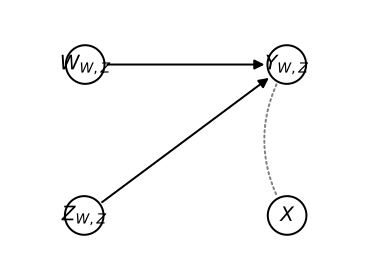

In [14]:
# Creation of a counterfactual graph
recursive_cf_graph, recursive_new_event = make_counterfactual_graph(
    figure_9a.graph, markov_pillow_event
)

assert recursive_new_event is not None, "ID* line 5 failed, return Zero()"
print("Passed ID* line 5")

recursive_cf_graph.draw()

### C-component {Y @ -X, X}, line 6
When we calculate the C-components for the recursive_cf_graph we omit the nodes W @ {W,Z} and Z @ {W,Z} for being self-intervened nodes. This leaves only one C-component, so line is not triggered and we move to line 7.

In [15]:
nodes = set(node for node in recursive_cf_graph.nodes() if is_not_self_intervened(node))
if recursive_cf_graph.subgraph(nodes).is_connected():
    print("Only 1 c-component, move past line 6")

Only 1 c-component, move past line 6


### C-component {Y @ -X, X}, line 8
When there is only one C-component we first check for another kind of inconsistency in the event. 

In [16]:
# Here is line 8.  We check for inconsistencies in the subscripts
interventions = get_cf_interventions(recursive_cf_graph.nodes())
evidence = get_evidence(recursive_new_event)
conflicts = [
    (intervention, ev)
    for intervention, ev in itt.product(interventions, evidence)
    if intervention.name == ev.name and intervention.star != ev.star
]
assert len(conflicts) == 0, "ID* line 8 found inconsistencies, return Unidentifiable"
print("Passed ID* line 8")

Passed ID* line 8


### C-component {Y @ -X, X}, line 9
If there is no inconsistency on line 8 we return the probability for this C-component on line 9.

In [17]:
# We have reached line 9, return the probability.
print(
    "Probability returned: ",
    P[get_cf_interventions(recursive_cf_graph.subgraph(nodes))](node.get_base() for node in nodes),
)

Probability returned:  P(X @ (-W, -Z), Y @ (-W, -Z))


## Probability Results for each C-component
Here are the probabilities for each C-component. Although we only showed the steps for one C-component the others are straightforward to follow in a similar manner

In [18]:
# Previous computed probabilities retunred for each C_component
probabilities = [P(W @ -X), P(X @ (-W, -Z), Y @ (-W, -Z)), P(D), P(Z @ -D)]
for i, c_component in enumerate(C_components):
    print(f"Probability returned for ID* {str(c_component):{23}}: ", probabilities[i])

Probability returned for ID* frozenset({Z})         :  P(W @ -X)
Probability returned for ID* frozenset({X, Y @ -X}) :  P(X @ (-W, -Z), Y @ (-W, -Z))
Probability returned for ID* frozenset({D})         :  P(D)
Probability returned for ID* frozenset({W @ -X})    :  P(Z @ -D)


## Putting it all together after recursion, Back to line 6
Having finished the four recursive calls to **ID*** performed on line 6, we return to line 6 to perform the final operations.

First we need the summand, we will sum over all the variables which are in the graph but not in the event. Our event on line 6 is {Y @ -X: -Y, X: +X, Z @ -D: -Z, D: -D}, which leaves W as the only variable in the summand.

Second we need the product of the probabilities returned from our recursive **ID*** calls.


In [19]:
summand = get_free_variables(cf_graph, input_event)
# Combine the summand with the product of the probabilities
walkthrough_result = Sum.safe(Product.safe(probabilities), summand)
walkthrough_result = canonicalize(walkthrough_result)

## Final Checkpoint
We will perform a check to make sure our id_star implementation is equal to the expected result in (I. Shpitser, J. Pearl 2008)

In [20]:
# standardize the walkthrough result
walkthrough_result = canonicalize(walkthrough_result)
# get the result from actually running id_star on the example
algorithm_result = canonicalize(id_star(figure_9a.graph, input_event))

# get the result from (I. Shpitser, J. Pearl 2008)
expected = Sum[W](P(Y @ (-z, -w), X @ (-z, -w)) * P(Z @ -d) * P(W @ -x) * P(D))
expected = canonicalize(expected)


assert (
    expected == algorithm_result == walkthrough_result
), "expected was not equal to the result in (I. Shpitser, J. Pearl 2008)"
print("id_star implementation is equal to the result from (I. Shpitser, J. Pearl 2008)")

id_star implementation is equal to the result from (I. Shpitser, J. Pearl 2008)


# IDC* Algorithm

The **IDC*** algorithm, like its counterpart **IDC**, is shorter because it leverages the **ID*** algorithm. 


The first line fails if $\gamma$ is inconsistent. **IDC** did not have an equivalent line, since we can assume $P(\mathbf{v})$ is positive. The problem with counterfactual distributions is there is no simple way to prevent non-positive distributions spanning multiple worlds from arising, even if the original P(v) was positive—hence the explicit check. 

1. if $\mathbf{{ID}^*}(G,\delta)=0$, return **UNDEFINED**

The second line constructs the counterfactual graph, except since make-cg can only take conjunctions, we provide it with a joint counterfactual γ ^ δ. 

2. $(G',\gamma'\wedge\delta')=\mathbf{make-cg}(G,\gamma\wedge\delta)$

Line 3 returns 0 if an inconsistency was detected. 

3. if $\gamma'\wedge\delta' =$  **INCONSISTENT**, return $0$


Line 4 of **IDC*** is the central line of the algorithm and is analogous to line 1 of **IDC**. In **IDC**, we moved value assignment $Z = z$ from being observed to being fixed if there were no back-door paths from $Z$ to the outcome variables $\mathbf{Y}$ given the context of the effect of $do(\mathbf{x})$. Here in **IDC***, we move a counterfactual value assignment $Y_\mathbf{x} = y$ from being observed (that is being a part of $\delta$), to being fixed (that is appearing in every subscript of $\gamma'$) if there are no back-door paths from $Y_\mathbf{x}$ to the counterfactual of interest $\gamma'$.

$$\newcommand\ci{\perp\!\!\!\perp}$$
$$\newcommand{\ubar}[1]{\underset{\bar{}}{#1}}
\newcommand{\obar}[1]{\overset{\bar{}}{#1}}$$

4. if $(\exists y_\mathbf{x}\in\delta')$ s.t. $(Y_\mathbf{x} \ci \gamma')_{G'_{\ubar{y_\mathbf{x}}}}$, return $\mathbf{IDC^*}(G, \gamma'_{y_\mathbf{X}},\delta'\backslash\{y_{\mathbf{X}}\})$

Finally, line 5 of **IDC*** is the analogue of line 2 of **IDC**, we attempt to identify a joint counterfactual probability, and then obtain a conditional counterfactual probability from the result.

5. else, let $P'=\mathbf{ID^*}(G,\gamma'\wedge\delta')$. return $\frac{P'}{P'(\delta)}$

In [21]:
# Imports needed for idc_star walkthrough
from y0.algorithm.identify.idc_star import (
    idc_star,
    get_remaining_and_missing_events,
    get_new_outcomes_and_conditions,
    cf_rule_2_of_do_calculus_applies,
)
from y0.examples import tikka_figure_2
from y0.algorithm.identify.utils import Unidentifiable
from y0.algorithm.identify.cg import make_counterfactual_graph

# Walkthrough of the IDC* Algorithm
Now we will do a walkthrough an example using the **IDC*** algorithm. We will use a different graph than we did for **ID*** , here following an example from (S. Tikka 2022). 

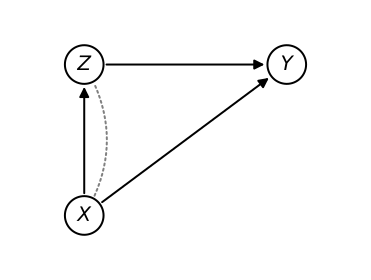

In [22]:
input_graph = tikka_figure_2.graph
input_graph.draw()

In [23]:
input_outcome = {Y @ -x: -y}
input_condition = {X: +x, Z @ -x: -z}

# IDC* line 1
The first line of **IDC*** checks that the **ID*** algorithm with the input graph and input condition will not return 0. It is ok if **ID*** is unidentifiable as long as it does not return 0 for being inconsistent on line 2 or line 5.


In [24]:
try:
    if isinstance(id_star(input_graph, input_condition), Zero):
        raise ValueError("The ID* algorithm returned 0, so IDC* cannot be applied.")
    else:
        print("line 1 IDC* algorithm: ID* algorithm is not inconsistent.")

except Unidentifiable:
    print("line 1 IDC* algorithm: ID* algorithm is not identifiable, but is also not inconsistent.")

line 1 IDC* algorithm: ID* algorithm is not identifiable, but is also not inconsistent.


# IDC* line 2
The second line of IDC* creates a counterfactual graph. Because **make_counterfactual_graph** doesn't consider outcome separate from condition, these are combined for the creation of the counterfactual graph. The new event from **make_counterfactual_graph** is written $\gamma'\wedge\delta'$ for **IDC*** . We note that this differs from the graph presented in (S. Tikka 2022) as they displayed the parallel worlds graph for the query and not the counterfactual which removes nodes that are not ancestors of the event.

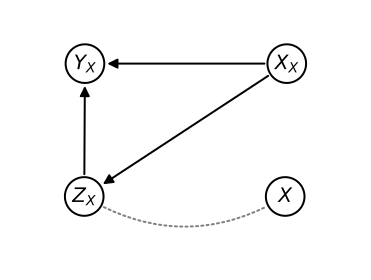

In [25]:
idc_cf_graph, new_idc_events = make_counterfactual_graph(
    input_graph, input_outcome | input_condition
)
idc_cf_graph.draw()

# IDC* line 3
The third line of IDC* checks that the counterfactual graph did not return **INCONSISTENT**.  We check that $\gamma'\wedge\delta'$ is not None.

In [26]:
# We check that the new event $\gamma'\wedge\delta'$ is not inconsistent
assert new_idc_events is not None, "IDC* line 3 failed, return Zero()"
print("Passed IDC* line 3")

Passed IDC* line 3


# Prior to IDC* line 4
Although not explicitly outlined in the algorithm, an supplementary step is incorporated here to partition $\gamma'\wedge\delta'$ into $\gamma'$ and $\delta'$ for line 4. In the case of this simple example, no nodes were merged during the process of **make_counterfactual_graph** so we have $\gamma=\gamma'$ and $\delta=\delta'$.

In [27]:
idc_new_outcomes, idc_new_conditions = get_new_outcomes_and_conditions(
    new_idc_events, input_outcome, input_condition
)
print(f"The new outcomes are {idc_new_outcomes}")
print(f"The new conditions are {idc_new_conditions}")

The new outcomes are {Y @ -X: -Y}
The new conditions are {X: +X, Z @ -X: -Z}


# IDC* line 4
This is the key line in the **IDC*** algorithm. First we will check if any of the conditions {X: +x, Z @ -x: -z} are d-separted from the outcome {Y @ -x: -y}. IF there exist a condition d-separated from the outcome we call **IDC*** with that condition added removed from the conditions, and if the removed condition is an ancestor of the outcomes we add it to the subscripts of the outcome variables. 

Here we find that `Z @ -x: -z` is d-separated from `Y @ -x: -y` so we will add `Z` to the subscripts of the outcome variables and remove `Z` from the conditions.

In [28]:
# Check each condition
for condition in idc_new_conditions:
    # Does rule 2 apply, i.e. is the condition d-separated from the outcomes
    if cf_rule_2_of_do_calculus_applies(idc_cf_graph, idc_new_outcomes, condition):
        idc_new_outcomes = {
            outcome.intervene(condition)
            if condition in idc_cf_graph.ancestors_inclusive(outcome)
            else outcome: value
            for outcome, value in idc_new_outcomes.items()
        }
        idc_new_conditions = {k: v for k, v in idc_new_conditions.items() if k != condition}

print(f"The new outcomes are {idc_new_outcomes}")
print(f"The new conditions are {idc_new_conditions}")

The new outcomes are {Y @ (-X, -Z): -Y}
The new conditions are {X: +X}


# IDC* line 4, recursive step
After adding interventions to $\gamma'$ and removing conditions from $\delta'$ we call **IDC*** with the input_graph and the updated conditions and interventions.
In this case we now have **IDC*** (input_graph, {Y @ (-X, -Z): -Y},{X: +X})

## IDC* recursive call line 1-3
Again on line 1 we find that id_star is not inconsistent, and when we create the counterfactual graph it returns a valid event.


line 1 IDC* algorithm: ID* algorithm is not inconsistent.
Passed IDC* line 3


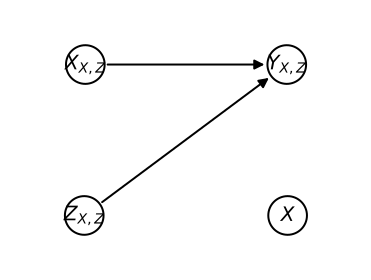

In [29]:
# Check if ID* algorithm is not inconsistent
try:
    if isinstance(id_star(input_graph, idc_new_conditions), Zero):
        raise ValueError("The ID* algorithm returned 0, so IDC* cannot be applied.")
    else:
        print("line 1 IDC* algorithm: ID* algorithm is not inconsistent.")
except Unidentifiable:
    print("line 1 IDC* algorithm: ID* algorithm is not identifiable, but is also not inconsistent.")

# create the counterfactual graph
recursive_idc_cf_graph, recursive_new_idc_events = make_counterfactual_graph(
    input_graph, idc_new_outcomes | idc_new_conditions
)
recursive_idc_cf_graph.draw()

# We check that the new event $\gamma'\wedge\delta'$ is not inconsistent
assert recursive_new_idc_events is not None, "IDC* line 3 failed, return Zero()"
print("Passed IDC* line 3")

## IDC* recursive call line 4
When we reach **IDC*** line 4 again we find that `X` is d-separated from `Y @ {X,Z}` so it is removed from the conditions. We also find that `Y @ {X,Z}` is not an descendant of `X` and so no new intervention is added to `Y @ {X,Z}`. This causes a call to **IDC*** with an empty $\delta$

In [30]:
# recover the outcomes and conditions from the event returned from make_counterfactual_graph
recursive_idc_new_outcomes, recursive_idc_new_conditions = get_new_outcomes_and_conditions(
    recursive_new_idc_events, idc_new_outcomes, idc_new_conditions
)

# Check each condition
for condition in recursive_idc_new_conditions:
    # Does rule 2 apply, i.e. is the condition d-separated from the outcomes
    if cf_rule_2_of_do_calculus_applies(
        recursive_idc_cf_graph, recursive_idc_new_outcomes, condition
    ):
        recursive_idc_new_outcomes = {
            outcome.intervene(condition)
            if condition in recursive_idc_cf_graph.ancestors_inclusive(outcome)
            else outcome: value
            for outcome, value in recursive_idc_new_outcomes.items()
        }
        recursive_idc_new_conditions = {
            k: v for k, v in recursive_idc_new_conditions.items() if k != condition
        }

print(f"The outcomes after recursion are {recursive_idc_new_outcomes}")
print(f"The conditions after recursion are {recursive_idc_new_conditions}")

The outcomes after recursion are {Y @ (-X, -Z): -Y}
The conditions after recursion are {}


# Final recursive call
There is a final recursive call with an empty $\delta$ , however, with no conditions we can instead call **ID*** directly.

In [31]:
walkthrough_result_idc = id_star(input_graph, recursive_idc_new_outcomes)

# Final IDC* Checkpoint
We will perform a check to make sure our idc_star implementation is equal to the expected result in (S. Tikka 2022)

In [32]:
# standardize the walkthrough result
walkthrough_result_idc = canonicalize(walkthrough_result_idc)
# get the result from actually running idc_star on the example
algorithm_result_idc = idc_star(input_graph, input_outcome, input_condition)

# get the result from (S. Tikka 2022)
expected_idc = P(Y @ (-x, -z))
expected_idc = canonicalize(expected_idc)


assert (
    expected_idc == algorithm_result_idc == walkthrough_result_idc
), "expected was not equal to the result in (S. Tikka 2022)"
print("idc_star implementation is equal to the result from (S. Tikka 2022)")

idc_star implementation is equal to the result from (S. Tikka 2022)


In [34]:
old_condition = {Y @ -x: -y, Y @ -z: +y}
new_condition = {Y: -y, Y @ -z: +y}
old_outcome = {Y @ -w: -y}
new_outcome = {Y: -y}
# P(Y: +y | +y)
new_outcome = {Y: -y}
remain_condition, missing_condition = get_remaining_and_missing_events(new_condition, old_condition)
remain_condition, missing_condition

({Y @ -Z: +Y}, {Y @ -X: -Y})

In [35]:
expected_new_outcomes_and_conditions = {Y: -y}, {Y: -y, Y @ -z: +y}

In [36]:
get_new_outcomes_and_conditions(
    new_event=new_outcome | new_condition, outcomes=old_outcome, conditions=old_condition
)

({Y: -Y}, {Y @ -Z: +Y, Y: -Y})

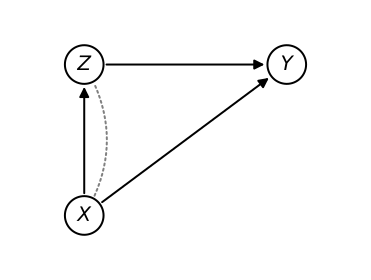

In [37]:
input_graph = tikka_figure_2.graph
input_graph.draw()

In [38]:
input_outcome = {Y @ -x: -y}
input_condition = {X: +x, Z @ -x: -z}
idc_star(input_graph, input_outcome, input_condition)

P(Y @ (-X, -Z))

In [39]:
variables = {Z @ -d}

variable = Z @ -d
isinstance(variable, CounterfactualVariable)
set(
    World(variable.interventions)
    for variable in variables
    if isinstance(variable, CounterfactualVariable)
)

NameError: name 'CounterfactualVariable' is not defined

In [ ]:
set(
    World(variable.interventions)
    for variable in variables
    if isinstance(variable, CounterfactualVariable)
)

In [ ]:
input_event5 = {Y @ (-D, -X): -Y, X: +X, Z: -Z}
graph5 = NxMixedGraph.from_edges(
    nodes=[Y @ (-D, -X), X, Z @ (-D, -X), Z, W @ (-D, -X), D @ (-D, -X), D, X @ (-D, -X)],
    directed=[
        (Z @ (-D, -X), Y @ (-D, -X)),
        (W @ (-D, -X), Y @ (-D, -X)),
        (D @ (-D, -X), Z @ (-D, -X)),
        (D, Z),
        (X @ (-D, -X), W @ (-D, -X)),
    ],
    undirected=[(Y @ (-D, -X), X), (Z @ (-D, -X), Z)],
)
district5 = {Z, Z @ (-D, -X)}
graph5.draw()

In [ ]:
figure_9c.graph.draw()

In [ ]:
graph = figure_9a.graph
event = {X: +x, D: -d, Z @ -d: -z}
worlds = extract_interventions(event)
pw_graph = make_parallel_worlds_graph(graph, worlds)
new_event = dict(event)
cf_graph = NxMixedGraph.from_edges(
    nodes=pw_graph.nodes(),
    directed=pw_graph.directed.edges(),
    undirected=pw_graph.undirected.edges(),
)
pw_graph.draw()

In [ ]:
worlds

In [ ]:
make_counterfactual_graph(figure_9a.graph, {X: +x, D: -d, Z @ -d: -z})

In [ ]:
id_star(figure_9a.graph, {Y @ -x: -y} | {X: +x, D: -d, Z @ -d: -z})

In [ ]:
idc_star(figure_9a.graph, {Y @ -x: -y}, {X: +x, D: -d, Z @ -d: -z})

In [ ]:
Z.intervene([D, D @ (-d, -x)])

In [ ]:
_upgrade_ordering([D, D @ (-d, -x)])

In [ ]:
_to_interventions((D @ (-D, -X), D))

# Examples of Notation


In [ ]:
W @ X

In [ ]:
~W

In [ ]:
P(Y @ X | ~X, Z @ D, D)

In [ ]:
{Y @ X: y}, {Y @ X: ~y}

In [ ]:
P(+Y @ +X)

In [ ]:
P({Y @ +x: y})

# Examples of `make_counterfactual_graph`

In [ ]:
input_events = [{Y @ (-w, -z): -y, X @ (-w, -z): -x}, {Z @ -d: -z}, {W @ -x: -w}, {D: -d}]
for input_event in input_events:
    actual_graph, actual_event = make_counterfactual_graph(figure_9a.graph, input_event)
    actual_graph.draw()
    plt.show()

In [ ]:
input_graph2 = figure_9a.graph
input_event2 = {Y @ -x: -y, X: +x, Z @ -d: -d, D: -d}
expected2 = Sum[W](P(Y @ (-z, -w), X @ (-z, -w)) * P(Z @ -d) * P(W @ -x) * P(D))
display(expected2)
display(id_star(input_graph2, input_event2))

In [ ]:
P(+Y | -y)

In [ ]:
str(idc_star(tikka_figure_2.graph, outcomes={Y @ -x: -y}, conditions={Z @ -x: -z, X: +x}))

In [ ]:
P(X, Y).conditional([])

In [ ]:
print(figure_9a.graph.nodes())
print(figure_9a.graph.directed)
print(figure_9a.graph.joint())
figure_9a.graph.draw()

# Counterfactual queries